# Deep Reinforcement Learning for Market Making Under a Hawkes Process-Based Limit Order Book Model

This notebook contains the core code used in the paper "*Deep Reinforcement Learning for Market Making Under a Hawkes Process-Based Limit Order Book Model*" by Bruno Gašperov and Zvonko Kostanjčar, currently under review in the IEEE Control Systems Letters (L-CSS). For any questions feel free to contact us at firstname.lastname@fer.hr (without carons). Hopefully you'll find this notebook useful.

In [2]:
# importing required packages
import numpy as np
import random
import matplotlib.pyplot as plt
import gym
import stable_baselines
from stable_baselines import SAC, TD3
import scipy.stats as ss
from gym import spaces, logger
import tensorflow as tf

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In what follows we define a highly customizable market making environment (simulator):

In [72]:
class marketmakingenv(gym.Env):    
    def __init__(self, T=100, dt=1, gamma=0.01, baselineintensities = [0.55,0.55,2.6,2.6,1.5,1.5,1,1], excitationmatrix = [[1.5, 0.4, 3, 0.5, 0, 2, 1, 0],[0.4, 1.5, 0.5, 3, 2, 0, 0, 1],[0.4, 1.2, 0.2, 0, 1.5, 0.5, 0.4, 0.4],[1.2, 0.4, 0, 0.2, 0.5, 1.5, 0.4, 0.4],[0, 0, 2, 0, 0, 0, 0, 0],[0, 0, 0, 2, 0, 0, 0, 0],[1, 0, 2, 0, 0, 1, 3, 0],[0, 1, 0, 2, 1, 0, 0, 3]], inventoryconstraint = 3, delta = 0.01, spread = 0.1, askprice = 100.05,
                bidprice = 99.95, s = 100.00, w1 = 8/30, w2=0.25, expdispar = 0.08, mtfee = 0.002, mmfee = 0, decayfactor=100, n1 = 0.45145, n2 = 0.495021633365654, n3 = 0, n4 = 0.5958326386388073, Z = 0.25):
        '''
        T - terminal time, dt - timestep, gamma - risk aversion parameter, baseline intensities, excitation matrix, inventory constraint,
        delta - tick size, spread - initial spread, askprice - initial ask-price, bidprice - initial bidprice, s - initial price
        w1 - probability of market maker's market order being aggressive, w2 - probability of market maker's limit order cancellation being aggressive
        expdispar - scale of the exponential distribution used for modeling jumps, mtfee - market taker fees, mmfee - market maker fees
        decay - beta decay factor (assumed to be fixed), n1 - parameter used for normalization of the spread state space variable
        n2 - parameter used for normalization of the spread state space variable, n3 - parameter used for normalization of the trend state space variable
        Z - the probability of execution of the market maker’s outstanding limit order standing at the best bid/ask price
        '''
        super(marketmakingenv, self).__init__()
        self.initial_parameters = (spread, askprice, bidprice, s, baselineintensities)
        self.t = 0 # initial time
        self.s = s # initial midprice value
        self.olds = s # initial old midprice value
        self.T = T # trading period length (terminal time)
        self.dt = dt # time step length
        self.q = 0 # initial inventory level
        self.oldq = 0 # initial old inventory level
        self.x = 0 # initial cash
        self.oldx = 0 # initial old cash
        self.w1 = w1 # probability of market maker's market order being aggressive
        self.w2 = w2 # probability of market maker's limit order cancellation being aggressive
        self.n1 = n1 # normalization of the spread state space variable
        self.n2 = n2 # normalization of the spread state space variable
        self.n3 = n3 # normalization of the trend state space variable
        self.n4 = n4 # normalization of the trend state space variable
        self.mtfee = mtfee
        self.mmfee = mmfee
        self.Z = Z
        self.expdispar = expdispar # exponential distribution parameter
        self.gamma = gamma # risk aversion parameter (part of penalty in the reward function)
        self.decayfactor = decayfactor
        self.excitationmatrix = excitationmatrix
        self.intensities = np.array(baselineintensities)
        self.defaultintensities = self.intensities # baseline intensities       
        self.done = False # done indicator (indicates whether the episode has finished)
        self.inventoryconstraint = inventoryconstraint # inventory constraint
        self.delta = delta # tick size
        self.spread = spread # initial spread
        self.limitscounter = 0 # counts the number of executions of the market maker's limit orders in an episode
        self.marketscounter = 0 # counts the number of executions of the market maker's market orders in an episode
        self.askprice = askprice # initial ask price
        self.bidprice = bidprice # initial bid price
        self.ask_order = np.inf # initial ask order
        self.bid_order = -np.inf # initial bid order
        self.action_space = spaces.Box(np.array([-1, -1]), np.array([1,1]),dtype=np.float32) # action space
        self.observation_space = spaces.Box(np.array([-1, -5, -5]), np.array([1, 5, 5]),dtype=np.float32) # observation space
        
    def step(self, action):
        '''Part 1: Canceling the existing (old) market maker's limit orders, if there are any. If such canceling
        is aggressive, intensities are updated as well as the bid-, ask-, mid-price and the spread.'''
        if (self.ask_order == self.askprice) and random.random() < self.w2: #aggressive limit sell cancelation
            jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # shifted exponential distribution
            self.askprice = np.round(self.askprice + jumpsize,2) # new ask-price
            self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
            self.spread = np.round(self.askprice-self.bidprice,2) # new spread
            self.intensities += np.array(self.excitationmatrix[5]) # new intensities
        if (self.bid_order == self.bidprice) and random.random() < self.w2: #aggressive limit buy cancelation
            jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # shifted exponential distribution
            self.bidprice = np.round(self.bidprice - jumpsize,2) # new ask-price         
            self.s = np.round((self.askprice+self.bidprice)/2,3) # new ask-price
            self.spread = np.round(self.askprice-self.bidprice,2) # new spread
            self.intensities += np.array(self.excitationmatrix[4]) # new intensities
        self.ask_order, self.bid_order = np.inf, -np.inf # cancel all existing orders 
        self.oldx, self.olds, self.oldq = self.x, self.s, self.q # save old cash, price and inventory
        self.reward = 0 # initialize reward
        assert self.askprice > self.bidprice # sanity checking
        '''Part 2: Setting new limit orders and checking inventory constraints'''
        self.ask_order, self.bid_order = np.round(self.askprice + action[0],2), np.round(self.bidprice - action[1],2) # setting new limit orders
        if self.q <= -self.inventoryconstraint: # if the side is saturated ignore the ask order
            self.ask_order = np.inf
        if self.q >= self.inventoryconstraint:  # if the side is saturated ignore the bid order
            self.bid_order = -np.inf
        if self.ask_order <= self.bid_order: # ignore non-sensical limit orders
            self.ask_order, self.bid_order = np.inf, -np.inf #
        '''Part 3: Effects of setting the ask limit order.'''
        if self.ask_order <= self.bidprice: # treating this case as a market sell
            if random.random() < 1-self.w1: # non-aggressive market sell
                if self.q > -self.inventoryconstraint: # checking the inventory constraint
                    self.q -= 1
                    self.marketscounter += 1
                    self.x += (1-self.mtfee)*self.bidprice
                    self.intensities += np.array(self.excitationmatrix[7])
                self.ask_order = np.inf # canceling the ask order
                self.bid_order = -np.inf # canceling the bid order
            else: # aggressive market sell
                if self.q > -self.inventoryconstraint: # checking the inventory constraint
                    jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2)
                    self.q -= 1
                    self.marketscounter += 1
                    self.x += (1-self.mtfee)*(self.bidprice-jumpsize/2) # simplifying assumption
                    self.intensities += np.array(self.excitationmatrix[1])
                self.ask_order = np.inf # canceling the ask order
                self.bid_order = -np.inf # canceling the bid order
                self.bidprice = np.round(self.bidprice - jumpsize,2) # new bid-price
                self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                self.spread = np.round(self.askprice-self.bidprice,2) # new spread
        elif self.ask_order < self.askprice: # agressive ask limit order
                self.askprice = np.round(self.ask_order, 2) # new ask-price 
                self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                self.intensities += np.array(self.excitationmatrix[3])
        else:
                pass
        '''Part 4: Effects of setting the bid limit order.'''
        if self.bid_order >= self.askprice: # treating this case as a market buy
            if random.random() < 1-self.w1: # non-aggressive market buy
                if self.q < self.inventoryconstraint: # checking the inventory constraint
                    self.q += 1
                    self.marketscounter += 1
                    self.x -= (1+self.mtfee)*self.askprice
                    self.intensities += np.array(self.excitationmatrix[6])
                self.ask_order = np.inf # canceling the ask order
                self.bid_order = -np.inf # canceling the bid order
            else: # aggressive market buy
                if self.q < self.inventoryconstraint: # checking the inventory constraint
                    jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2)
                    self.q += 1
                    self.marketscounter += 1
                    self.x -= (1+self.mtfee)*(self.askprice+jumpsize/2) # simplifying assumption 
                    self.intensities += np.array(self.excitationmatrix[0])
                self.ask_order = np.inf # canceling the ask order
                self.bid_order = -np.inf # canceling the bid order
                self.askprice = np.round(self.askprice + jumpsize,2) # new ask-price
                self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                self.spread = np.round(self.askprice-self.bidprice,2) # new spread
        elif self.bid_order > self.bidprice: # agressive bid limit order
                self.bidprice = np.round(self.bid_order, 2) # new bid-price
                self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                self.intensities += np.array(self.excitationmatrix[2])
        else:
                pass 
        self.reward += self.x+self.q*self.s-self.oldx-self.oldq*self.olds # first part of the reward (directly due to the action, no time has passed)
        next_t_change = self.t+self.dt # time of the next time step
        while self.t < next_t_change: #as long as the end of the timestep is not reached
            time_to_next_event = np.random.exponential(1/sum(self.intensities)) # exponentially distributed time to the next event
            event_type = random.choices([1,2,3,4,5,6,7,8], cum_weights=np.cumsum(self.intensities))[0] # the type of the next event
            if self.t+time_to_next_event<next_t_change: # if the event time is within the timestep
                self.oldx, self.olds, self.oldq = self.x, self.s, self.q # saving the old cash, price and inventory
                self.t += time_to_next_event # increase the current time
                oldintensities = self.intensities # saving the old intensities
                self.intensities = self.defaultintensities*(1-np.exp(-self.decayfactor*time_to_next_event))+self.intensities*np.exp(-self.decayfactor*time_to_next_event) # new intensities
                assert self.askprice > self.bidprice # sanity check
                if random.random() >= sum(self.intensities)/sum(oldintensities): # discard the event in this case
                    event_type == 0
                if event_type == 1: #event type 1 => aggressive market buy   
                    jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # jump size
                    self.askprice = np.round(self.askprice + jumpsize,2) # new ask-price
                    self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                    self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                    if self.ask_order < self.askprice: # in this case the ask order must have gotten executed
                        prob = 1
                    elif self.ask_order == self.askprice: # in this case we assume the probability of 25%
                        prob = 0.25 
                    else: # else it does not get executed
                        prob = 0
                    if self.ask_order < np.inf and self.q > -self.inventoryconstraint and random.random() < prob: # conditions needed for the execution to take place
                        self.q -= 1
                        self.limitscounter += 1
                        self.x += self.ask_order - self.mmfee*self.ask_order
                        self.ask_order = np.inf # ask order is now executed and does not exist anymore
                    if self.ask_order < self.askprice:
                        self.ask_order = np.inf # the order is canceled (would be executed but can't due to the inventory constraint)
                    self.intensities += np.array(self.excitationmatrix[0])
                elif event_type == 2: #event type 2 => aggressive market sell    
                    jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # jump size
                    self.bidprice = np.round(self.bidprice - jumpsize,2) # new bid-price
                    self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                    self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                    if self.bid_order > self.bidprice: # in this case the bid order must have gotten executed
                        prob = 1
                    elif self.bid_order == self.bidprice: # in this case we assume the probability of 25%
                        prob = 0.25 
                    else: # else it does not get executed
                        prob = 0
                    if self.bid_order > -np.inf and self.q < self.inventoryconstraint and random.random() < prob: # conditions needed for the execution to take place
                        self.q += 1
                        self.limitscounter += 1
                        self.x -= self.bid_order + self.mmfee*self.bid_order #+ 0.006*env.s
                        self.bid_order = -np.inf # bid order is now executed and does not exist anymore
                    if self.bid_order > self.bidprice:
                        self.bid_order = -np.inf # the order is canceled (would be executed but can't due to the inventory constraint)
                    self.intensities += np.array(self.excitationmatrix[1])
                elif event_type == 3 and (self.askprice-self.bidprice >= np.round(2*self.delta,2)): # event type 3 => aggressive limit buy
                    # only happens if the spread is larger than or equals two ticks (otherwise obviously can not happen)
                    jumpsize = np.inf
                    while jumpsize >= np.round(self.askprice - self.bidprice,2): 
                        jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # this is in essence a truncated exponential, since there now exists an upper limit to the jump size
                    self.bidprice = np.round(self.bidprice + jumpsize,2) # new bid-price
                    self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                    self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                    self.intensities += np.array(self.excitationmatrix[2]) # new intensities
                elif event_type == 4 and (self.askprice-self.bidprice >= np.round(2*self.delta,2)): # event type 4 => aggressive limit sell
                    jumpsize = np.inf
                    while jumpsize >= np.round(self.askprice - self.bidprice,2):
                        jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # this is in essence a truncated exponential, since there now exists an upper limit to the jump size
                    self.askprice = np.round(self.askprice - jumpsize,2) # new ask-price
                    self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                    self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                    self.intensities += np.array(self.excitationmatrix[3]) # new intensities
                elif event_type == 5 and self.bidprice>=np.round(self.bid_order+self.delta,2): # event type 5 => agressive limit buy cancellation
                    jumpsize = np.inf
                    if self.bid_order>-np.inf: # if the market maker's bid order still exists, it provides an upper bound to the jump size
                        while jumpsize > np.round(self.bidprice-self.bid_order,2):
                            jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # generating jump size
                    else: # in this case there is no upper bound to the jump size
                        jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # generating jump size
                    self.bidprice = np.round(self.bidprice - jumpsize,2) # new bid-price
                    self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                    self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                    self.intensities += np.array(self.excitationmatrix[4]) # new intensities
                elif event_type == 6 and self.askprice<=np.round(self.ask_order-self.delta,2):  # event type 6 => agressive limit sell cancellation
                    jumpsize = np.inf
                    if self.ask_order<np.inf: # if the market maker's ask order still exists, it provides an upper bound to the jump size
                        while jumpsize > np.round(self.ask_order-self.askprice,2):
                            jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # generating jump size
                    else: # in this case there is no upper bound to the jump size
                        jumpsize = np.round(np.random.exponential(self.expdispar)+0.01,2) # generating jump size
                    self.askprice = np.round(self.askprice + jumpsize,2) # new ask-price
                    self.s = np.round((self.askprice+self.bidprice)/2,3) # new mid-price
                    self.spread = np.round(self.askprice-self.bidprice,2) # new spread
                    self.intensities += np.array(self.excitationmatrix[5])  # new intensities
                elif event_type == 7: # event type 7 => non-aggressive market buy
                    if self.ask_order == self.askprice and self.q > -self.inventoryconstraint and random.random()<self.Z: # checking conditions
                        self.q -= 1
                        self.limitscounter += 1
                        self.x += self.ask_order - self.mmfee*self.ask_order
                        self.ask_order = np.inf
                    self.intensities += np.array(self.excitationmatrix[6]) # new intensities
                elif event_type == 8: # event type 8 => non-aggressive market sell
                    if self.bid_order == self.bidprice and self.q < self.inventoryconstraint and random.random()<self.Z: # checking conditions
                        self.q += 1
                        self.limitscounter += 1
                        self.x -= self.bid_order + self.mmfee*self.bid_order
                        self.bid_order = -np.inf
                    self.intensities += np.array(self.excitationmatrix[7]) # new intensities
                else:
                    pass
                self.reward += self.x+self.q*self.s-self.oldx-self.oldq*self.olds-self.gamma*time_to_next_event*abs(self.oldq) # the reward function as explained in the paper
            else: # if the event time exceeds the end of the time step
                time_to_next_event=next_t_change-self.t
                self.t += time_to_next_event # setting time to beginning of the next time-step
                self.intensities = self.defaultintensities*(1-np.exp(-self.decayfactor*time_to_next_event))+self.intensities*np.exp(-self.decayfactor*time_to_next_event) #updating intensities
                self.reward -= self.gamma*time_to_next_event*abs(self.q) # reward function
        self.state = np.array([self.q/self.inventoryconstraint, (self.spread-self.n1)/self.n2, (self.intensities[0]+self.intensities[-2]-self.intensities[1]-self.intensities[-1]-self.n3)/self.n4]) # state space formulation
        if self.t >= self.T: # if the end of the episode is reached
            self.done = True
        return self.state, self.reward, self.done, {}

    def reset(self):
        self.t = 0 # initial time
        self.s = self.initial_parameters[3] # initial midprice value
        self.olds = self.initial_parameters[3] # initial old midprice value
        self.q = 0 # initial inventory level
        self.oldq = 0 # initial old inventory level
        self.x = 0 # initial cash
        self.oldx = 0 # initial old cash
        self.intensities = np.array(self.initial_parameters[4])
        self.defaultintensities = self.intensities # baseline intensities
        self.done = False # done indicator (indicates whether the episode has finished)
        self.limitscounter = 0  # counts the number of executions of the market maker's limit orders in an episode
        self.marketscounter = 0 # counts the number of executions of the market maker's market orders in an episode
        self.spread = self.initial_parameters[0] # initial spread
        self.askprice = self.initial_parameters[1] # initial ask price
        self.bidprice = self.initial_parameters[2] # initial bid price
        self.ask_order = np.inf # initial ask order
        self.bid_order = -np.inf # initial bid order
        self.state = np.array([self.q/self.inventoryconstraint, (self.spread-self.n1)/self.n2, (self.intensities[0]+self.intensities[-2]-self.intensities[1]-self.intensities[-1]-self.n3)/self.n4]) # state space (normalized)
        return self.state 
 
    def render(self):
        print(self.state)

Determining normalization parameters.

In [73]:
def return_normalization_parameters(T=10000, n1=0, n2=1, n3=0, n4=1):
    env = marketmakingenv(T=T, n1=n1, n2=n2, n3=n3, n4=n4)
    for i in range(1):
        observation = env.reset()
        while True:
            spreads.append(env.state[1])
            alphas.append(env.state[2])
            action = [np.random.uniform(0,1),np.random.uniform(0,1)]
            observation, reward, done, info = env.step(action)
            if done:
                break
    env.close()
    return np.mean(spreads), np.std(spreads), np.mean(alphas), np.std(alphas)

In [70]:
n1_, n2_, n3_, n4_ = return_normalization_parameters(T=10000)

In [63]:
env = marketmakingenv(n1=n1_, n2=n2_, n3=n3_, n4=n4_)

Initializing the SAC model.

In [42]:
model = SAC("MlpPolicy", env, verbose=1, gamma=1, batch_size=512, learning_rate=0.0003, policy_kwargs=dict(act_fun=tf.nn.relu, layers=[64,64]))#, buffer_size=100000, batch_size=512)# policy_kwargs=dict(act_fun=tf.nn.tanh, layers=[12, 12]))#, nstep=64*8,  buffer_size=100000)

In [64]:
model.set_env(env)

Model training

In [65]:
model.learn(1000000) 

--------------------------------------
| current_lr              | 0.0003   |
| episodes                | 4        |
| fps                     | 383      |
| mean 100 episode reward | -6.6     |
| n_updates               | 0        |
| time_elapsed            | 1        |
| total timesteps         | 400      |
--------------------------------------


KeyboardInterrupt: 

Saving and loading models:

In [66]:
model.save("model1")
model = SAC.load("model1")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [78]:
# Test the trained agent
def tester(evaluationlen, strategy_name,a=None,b=None):
    rreturns3 = []
    pvalues3 = []
    qqs3 = []
    qqsw = []
    ppvs = []
    allqs = []
    ssss = []
    marketcounters = []
    limitcounters = []
    for i in range(evaluationlen):
        obs = env.reset()
        returns3 = []
        qs3 = []
        pvs= []
        while True:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            returns3.append(reward)
            pvs.append(env.x+env.q*env.s)
            qs3.append(env.q)
            #print('obs=', obs, 'reward=', reward, 'done=', done)
            if done:
                pvalues3.append(env.x+env.q*env.s)
                #print("Goal reached!", "reward=", reward)
                break
                #print("Episode end")
        qqs3.append(qs3[-1])
        allqs.append(qs3)
        ppvs.append(pvs)
        qqsw.append(np.mean(abs(np.array(qs3))))
        rreturns3.append(np.sum(returns3))
        ssss.append(env.s)
        marketcounters.append(env.marketscounter)
        limitcounters.append(env.limitscounter)
    return rreturns3, pvalues3, qqs3, qqsw, ppvs, allqs, ssss, marketcounters, limitcounters

In [76]:
rreturns1, pvalues1, qqs1, qqsw1, ppvs1, allqs1, ssss1, marketcounters1, limitcounters1 = tester(100,"abc",0.26,-0.13)

In [10]:
rreturns2, pvalues2, qqs2, qqsw2, ppvs2, allqs2, ssss2, marketcounters2, limitcounters2 = tester(0.26,-0.13)

In [79]:
rreturns3, pvalues3, qqs3, qqsw3, ppvs3, allqs3, ssss3, marketcounters3, limitcounters3 = tester(100,"abc",0.26,-0.13)

In [44]:
rreturns4, pvalues4, qqs4, qqsw4, ppvs4, allqs4, ssss4, marketcounters4, limitcounters4  = tester(0.25, -0.13)

In [47]:
np.std(pvalues4)

5.114928574827794

In [30]:
rreturns5, pvalues5, qqs5, qqsw5, ppvs5, allqs5  = tester(0.2, -0.1)

In [35]:
rreturns6, pvalues6, qqs6, qqsw6, ppvs6, allqs6  = tester(0.2, -0.1)

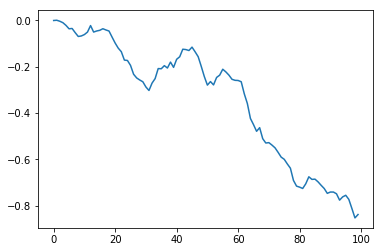

In [22]:
plt.plot(np.mean(np.array(ppvs1), axis=0))

KeyboardInterrupt: 

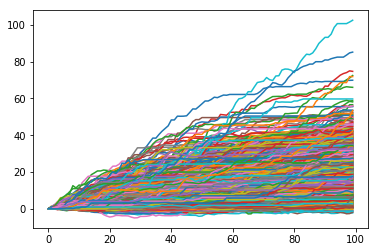

In [14]:
for i in np.array(ppvs1):
    plt.plot(i)

In [10]:
np.mean(abs(np.array(allqs1)))

0.3771

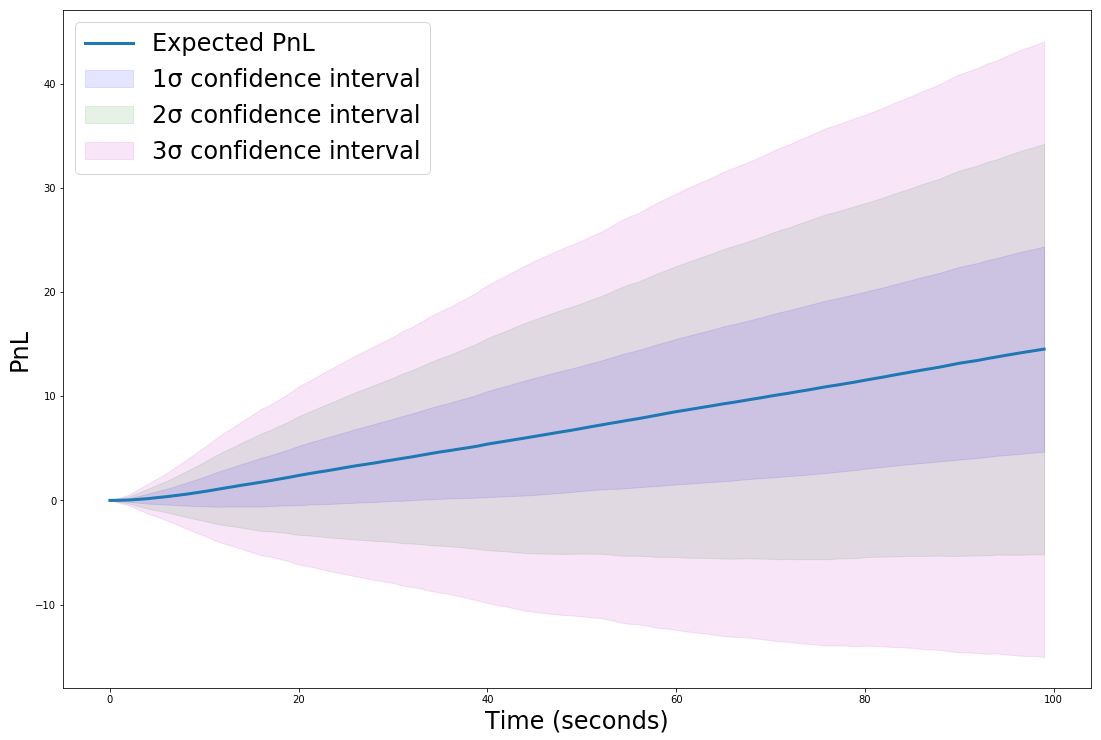

In [30]:
y = np.mean(np.array(ppvs1), axis=0)
ci = np.std(np.array(ppvs1), axis=0)
x = list(range(len(y)))
#y2 = np.mean(np.array(ppvs2), axis=0)
#ci2 = np.std(np.array(ppvs2), axis=0)
#y3 = np.mean(np.array(ppvs3), axis=0)
#ci3 = np.std(np.array(ppvs3), axis=0)
fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(15,10))
fig.tight_layout()
ax1.plot(x,y,lw=3)
ax1.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
#ax1.plot(x,y2)
#ax1.plot(x,y3)
ax1.fill_between(x, (y-2*ci), (y+2*ci), color='g', alpha=.1)
ax1.fill_between(x, (y-3*ci), (y+3*ci), color='m', alpha=.1)
ax1.set_xlabel("Time (seconds)", fontsize=24)
ax1.set_ylabel("PnL", fontsize=24)
ax1.legend(["Expected PnL","1σ confidence interval","2σ confidence interval","3σ confidence interval"], loc="upper left", fontsize=24)
#ax1.xlabel("Time (s)")
#for i in np.array(ppvs1):
 #   ax1.plot(i, alpha=0.1)
plt.savefig("PLgraph_pnl.pdf", bbox_inches='tight')

In [380]:
np.mean(pvalues3) # 11, 3.54. fixni 16, 9

2.9889079499999993

In [139]:
np.std(pvalues3)

0.0

In [ ]:
# 13.712450000000004 4.693038088221723 MODEL
# 14.81 10.820112859739302

In [140]:
np.mean(qqsw)

4.03605

In [107]:
x1, x2, x3, x4, x5 = tester(0.5) #model

(array([22.,  8.,  9.,  8., 10.,  8.,  9.,  8.,  9.,  9.]),
 array([ 0. ,  8.5, 17. , 25.5, 34. , 42.5, 51. , 59.5, 68. , 76.5, 85. ]),
 <a list of 10 Patch objects>)

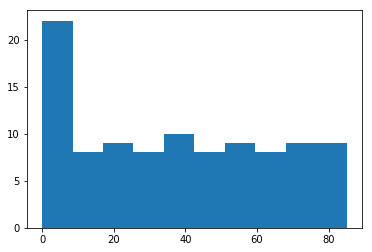

In [109]:
plt.hist(x5)

In [51]:
tester(0.5) #default 14 11

(-6.984495208470019,
 21.627824999999905,
 9.95816914118143,
 [35.12000000000057,
  13.9399999999996,
  44.26000000000067,
  14.400000000000546,
  23.94000000000051,
  20.469999999999573,
  18.84999999999951,
  14.339999999998327,
  13.869999999998981,
  15.104999999997744,
  13.020000000000664,
  9.559999999998865,
  36.45500000000038,
  34.3300000000001,
  26.339999999999804,
  21.47999999999911,
  14.820000000000391,
  16.41499999999928,
  25.429999999999836,
  29.484999999999673,
  22.859999999999673,
  12.990000000000236,
  20.519999999999754,
  14.195000000000618,
  19.8799999999992,
  14.854999999998654,
  9.369999999999436,
  17.209999999999127,
  25.904999999999745,
  27.754999999999768,
  18.09999999999991,
  32.5299999999998,
  8.319999999998345,
  22.184999999999036,
  21.5600000000004,
  41.69000000000142,
  13.0949999999998,
  20.22999999999979,
  30.585000000001173,
  24.539999999999964,
  31.0849999999985,
  16.16999999999871,
  32.55000000000018,
  17.69999999999891,
 

In [113]:
tester(0.5)

(83.12450847780073, 89.15899505000002, 50.276163894624325)

In [141]:
tester(0.5)

(63.713183563908444, 96.3733391, 56.57308036817005)

In [162]:
tester(0.5)

(66.54073357562984, 83.78242475, 52.4407246376906)

In [170]:
tester(0.5)

(-808.5760536656906,
 61.70752499999999,
 44.42441289425642,
 [121.0150000000001,
  15.660000000000082,
  86.18999999999997,
  17.724999999999795,
  27.739999999999952,
  66.23000000000025,
  41.31999999999995,
  67.32,
  87.0099999999999,
  58.2000000000001,
  44.96999999999997,
  69.38500000000005,
  93.26999999999997,
  38.47000000000005,
  69.89999999999998,
  84.05499999999984,
  108.10999999999997,
  16.969999999999686,
  29.584999999999916,
  53.449999999999996,
  23.12000000000006,
  43.059999999999945,
  26.910000000000082,
  22.189999999999827,
  17.86000000000024,
  137.64,
  26.94999999999996,
  84.99000000000015,
  78.32500000000005,
  16.36000000000007,
  65.20999999999994,
  87.245,
  71.58000000000004,
  68.12,
  27.114999999999952,
  19.4200000000001,
  56.920000000000165,
  -3.5900000000001455,
  67.85000000000025,
  37.47999999999997,
  105.80000000000003,
  13.200000000000045,
  54.29000000000005,
  85.84000000000005,
  29.05000000000001,
  14.450000000000045,
  88.

In [58]:
plt.plot([tester(i/20)[1] for i in range(0,20,1)])

TypeError: tester() missing 1 required positional argument: 'y'

In [ ]:
[tester(i/20)[1] for i in range(0,20,1)]

In [ ]:
np.mean(rreturns3)

In [ ]:
np.mean(pvalues3)

In [ ]:
np.std(pvalues3)

In [ ]:
# možda ignorirati sve ovo

In [89]:
matrix1 = np.vstack(([model.predict([i/3,0,0], deterministic=True)[0] for i in range(-3,4)]))
#matrix2 = np.vstack(([model.predict([i/3,0.2,0], deterministic=True)[0] for i in range(-3,4)]))
#matrix3 = np.vstack(([model.predict([i/3,0.4,0], deterministic=True)[0] for i in range(-3,4)]))
#matrix4 = np.vstack(([model.predict([i/3,0.6,0], deterministic=True)[0] for i in range(-3,4)]))
#matrix5 = np.vstack(([model.predict([i/3,-0.2,0], deterministic=True)[0] for i in range(-3,4)]))
#matrix6 = np.vstack(([model.predict([i/3,-0.4,0], deterministic=True)[0] for i in range(-3,4)]))
#matrix7 = np.vstack(([model.predict([i/3,-0.6,0], deterministic=True)[0] for i in range(-3,4)]))

In [90]:
matrix = matrix1+matrix2+matrix3+matrix4+matrix5+matrix6+matrix7

In [96]:
model.predict(observation=[-1,0,0],state=[0,0,0])

(array([-0.7162807, -0.5455534], dtype=float32), None)

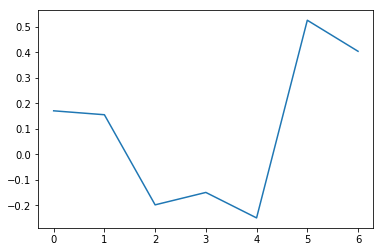

In [95]:
plt.plot(matrix1[:,1]-matrix1[:,0])

In [ ]:
import seaborn as sns
#from google.colab import files
sns.set_style("darkgrid")
plt.figure(figsize=(3.5,2.3333333333))
plt.xticks(ticks=[0,20,40,60,80,100],labels=[8225,8245,8265,8285,8305,8325],fontsize='xx-small') 
plt.yticks(fontsize='xx-small') 
plt.plot(t3[8225:8325], color="k", linewidth=2)
plt.plot(t6[8225:8325], color="r", alpha=0.4)
plt.plot(t7[8225:8325], color="b", alpha=0.4)
plt.xlabel("Environmental step", fontsize='xx-small')
plt.ylabel("Inventory level/scaled actions", fontsize='xx-small')
plt.legend(["Inventory","Bid offset (scaled)","Ask offset (scaled)"], fontsize='xx-small')
plt.tight_layout(0.4)
#plt.ticklabel_format(axis='x', scilimits=(0,0))
plt.savefig('gaspe4.pdf', dpi=300)
#files.download('gaspe4.pdf')

In [ ]:
matrix

In [126]:
pvalues

4.713585698807226

In [45]:
#mean terminal profit: 10.841392300000003 dunno5
#std terminal profit: 6.92577534073166 dunno5
#

In [46]:
from scipy.stats import kurtosis, skew, jarque_bera
print(np.mean(np.array(rreturns3)))
print(" mean utility: {}".format(np.mean(-np.exp(np.array(pvalues3)*(-0.05)))))
print(" mean terminal profit: {}".format(np.mean(np.array(pvalues3))))
print(" std terminal profit: {}".format(np.std(np.array(pvalues3))))
print(" kurtosis terminal profit: {}".format(kurtosis(np.array(pvalues3))))
print(" skew terminal profit: {}".format(skew(np.array(pvalues3))))
print(" Jarque Bera terminal profit: {}".format(jarque_bera(np.array(pvalues3))))
print(" 10th percentile terminal profit: {}".format(np.percentile(np.array(pvalues3),10)))
print(" 20th percentile terminal profit: {}".format(np.percentile(np.array(pvalues3),20)))
print(" 80th percentile terminal profit: {}".format(np.percentile(np.array(pvalues3),80)))
print(" 90th percentile terminal profit: {}".format(np.percentile(np.array(pvalues3),90)))
print(" mean terminal inventory: {}".format(np.mean(qqs3)))
print(" mean abs terminal inventory: {}".format(np.mean(abs(np.array(qqs3)))))
print(" std terminal inventory: {}".format(np.std(np.array(qqs3))))
print(" kurtosis terminal inventory: {}".format(kurtosis(np.array(qqs3))))
print(" skew terminal inventory: {}".format(skew(np.array(qqs3))))
print(" Jarque Bera terminal inventory: {}".format(jarque_bera(np.array(qqs3))))
print(" 10th percentile inventory: {}".format(np.percentile(np.array(qqs3),10)))
print(" 20th percentile inventory: {}".format(np.percentile(np.array(qqs3),20)))
print(" 80th percentile inventory: {}".format(np.percentile(np.array(qqs3),80)))                                                  
print(" 90th percentile inventory: {}".format(np.percentile(np.array(qqs3),90)))
print(" MAP: {}".format(np.mean(abs(np.array(qqs3)))))

13.894062869287222
 mean utility: -0.5293721264765152
 mean terminal profit: 14.30839945
 std terminal profit: 8.705230242461727
 kurtosis terminal profit: 1.8632601755517815
 skew terminal profit: 1.3123125495849086
 Jarque Bera terminal profit: (86.33662827491193, 0.0)
 10th percentile terminal profit: 5.444999999999995
 20th percentile terminal profit: 7.260999999999987
 80th percentile terminal profit: 20.153000000000006
 90th percentile terminal profit: 26.29962799999998
 mean terminal inventory: 0.03
 mean abs terminal inventory: 0.38
 std terminal inventory: 0.7543871685016919
 kurtosis terminal inventory: 3.267469736223081
 skew terminal inventory: 0.7191669392984641
 Jarque Bera terminal inventory: (106.20969019544512, 0.0)
 10th percentile inventory: -1.0
 20th percentile inventory: 0.0
 80th percentile inventory: 0.0
 90th percentile inventory: 1.0
 MAP: 0.38


In [46]:
sum(np.array(pvalues6)>0)/len(np.array(pvalues6)>0)

0.968

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

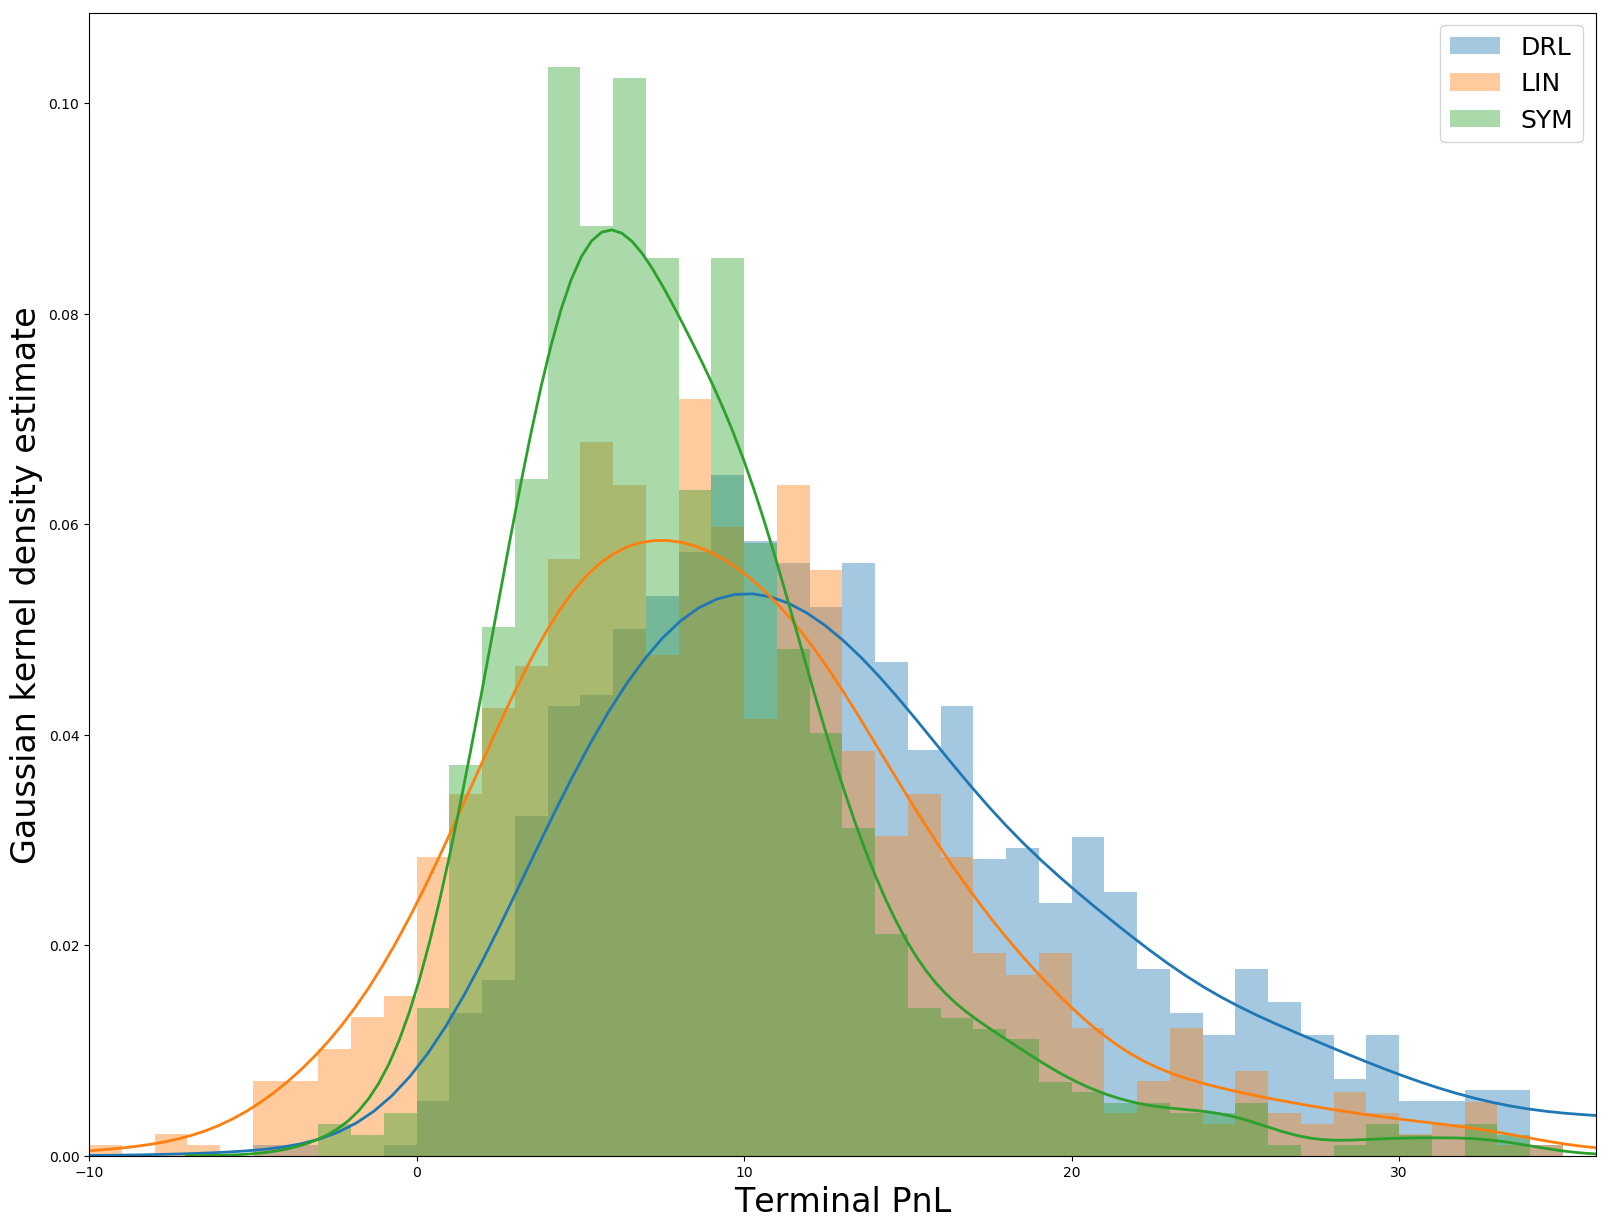

In [20]:
from matplotlib import pyplot
import seaborn as sns
plt.figure(figsize=(16, 12), dpi=100)
bins = np.arange(-10, 36, 1)
kwargs = dict(hist_kws={'alpha':0.4}, kde_kws={'linewidth':2})
sns.distplot(pvalues1, bins=bins, label="DRL", **kwargs)
sns.distplot(pvalues2, bins=bins, label="LIN", **kwargs)
sns.distplot(pvalues3, bins=bins, label="SYM", **kwargs)
#sns.distplot(pvalues4, bins=bins, label="DRL-NOISE", **kwargs)
pyplot.tight_layout()
pyplot.ylabel('Gaussian kernel density estimate', fontsize=24)
pyplot.xlabel('Terminal PnL', fontsize=24)
pyplot.legend(fontsize=18)
#plt.axis(x_range + y_range)
#pyplot.title("P&L distribution - original model")
plt.xlim(-10,36)
plt.savefig("PLgraph1.pdf", bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarnin

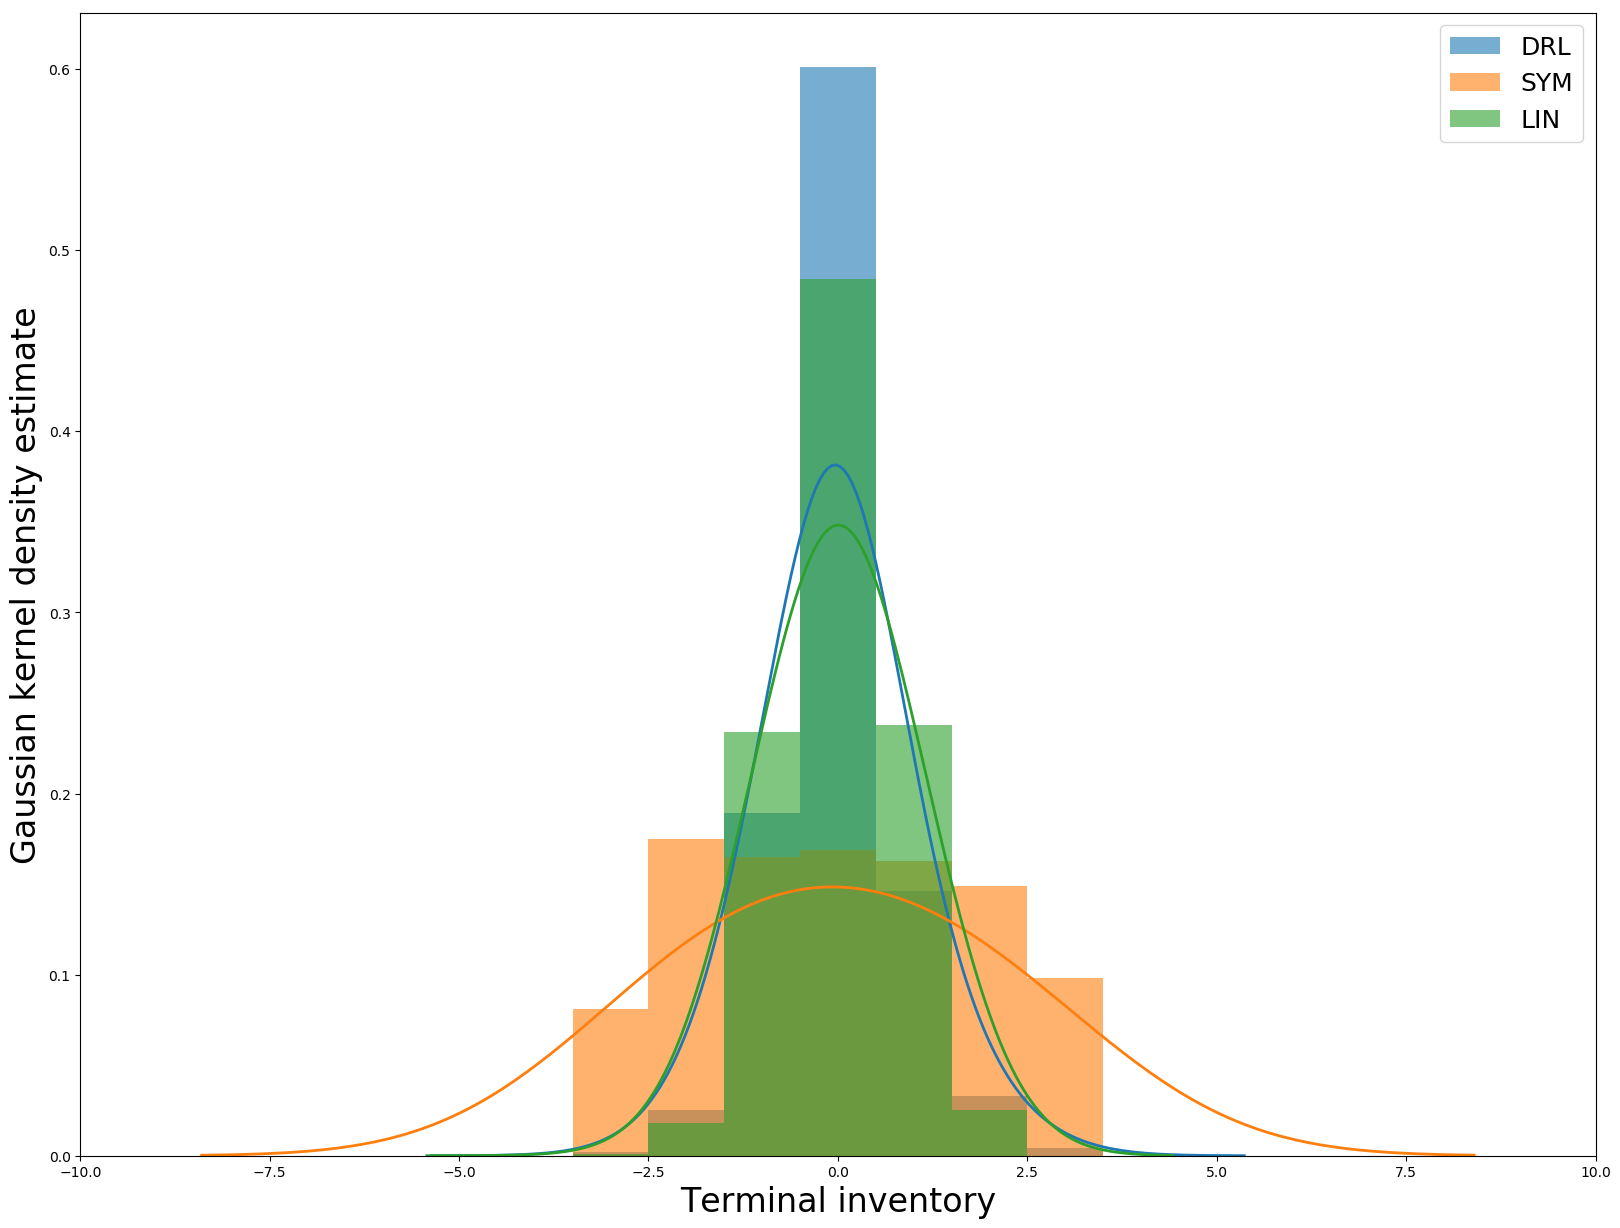

In [21]:
from matplotlib import pyplot
import seaborn as sns
plt.figure(figsize=(16, 12), dpi=100)
bins = np.arange(-55, 55, 10)/10
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2, 'bw':1})
sns.distplot(qqs1, bins=bins, label="DRL", **kwargs)
sns.distplot(qqs2, bins=bins, label="SYM", **kwargs)
sns.distplot(qqs3, bins=bins, label="LIN", **kwargs)
pyplot.tight_layout()
#sns.distplot(sym_final_qs, bins=bins, label="SYM", **kwargs)
pyplot.ylabel('Gaussian kernel density estimate', fontsize=24)
pyplot.xlabel('Terminal inventory', fontsize=24)
pyplot.legend(fontsize=18)
#plt.axis(x_range + y_range)
plt.xlim(-10,10)
#pyplot.title("Mean terminal inventory positions")
plt.savefig("PAPERFIG_INV_HIST.pdf", bbox_inches='tight')

In [194]:
sum(np.array(qqs2)==-2)

102

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

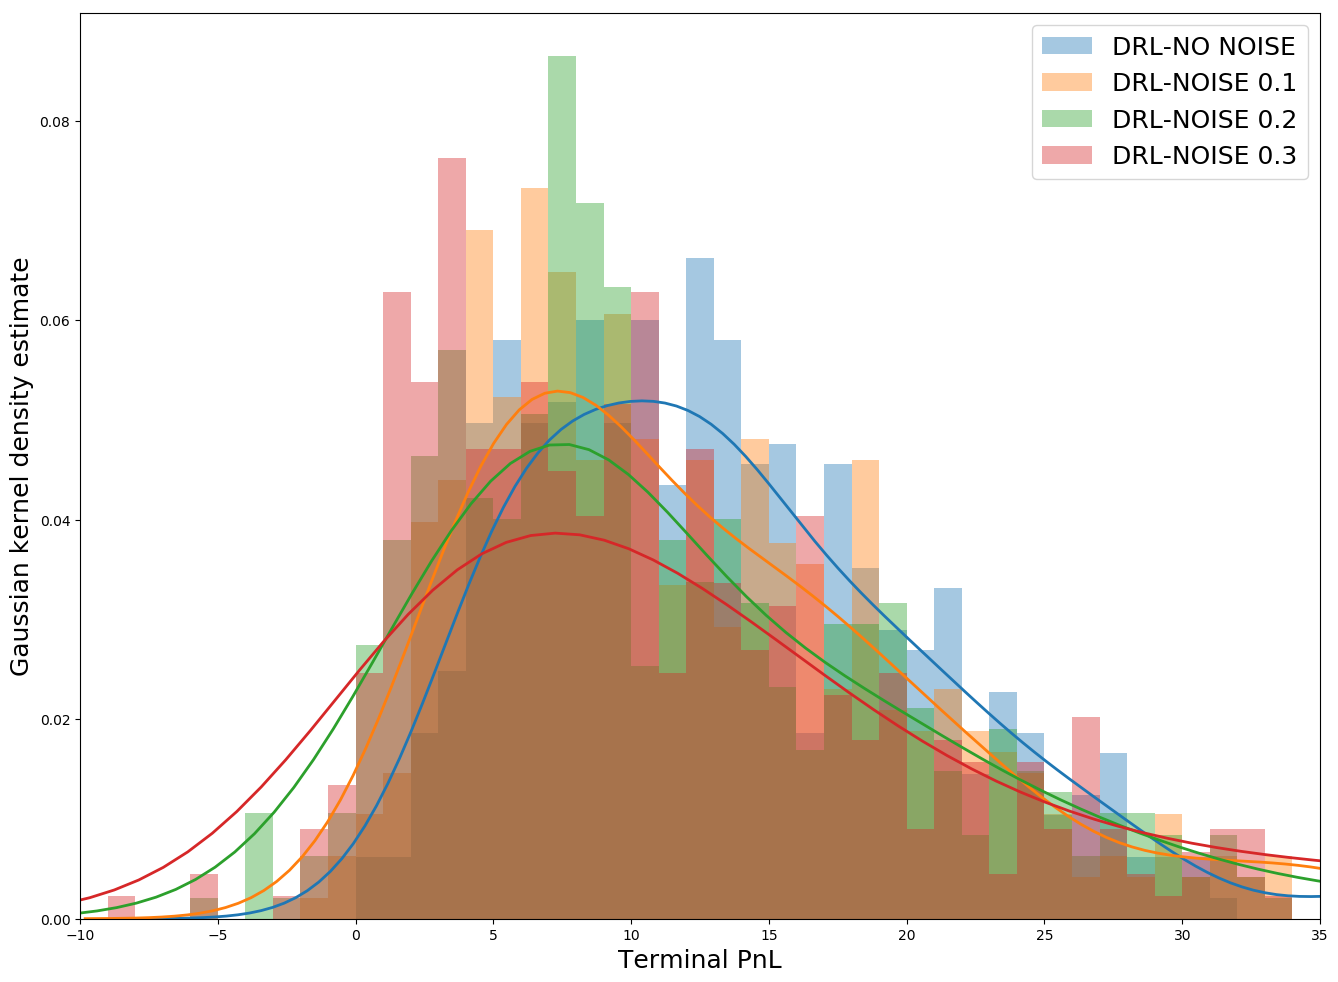

In [36]:
from matplotlib import pyplot
import seaborn as sns
plt.figure(figsize=(16, 12), dpi=100)
bins = np.arange(-10, 35, 1)
kwargs = dict(hist_kws={'alpha':0.4}, kde_kws={'linewidth':2})
sns.distplot(pvalues1, bins=bins, label="DRL-NO NOISE", **kwargs)
sns.distplot(pvalues4, bins=bins, label="DRL-NOISE 0.1", **kwargs)
sns.distplot(pvalues5, bins=bins, label="DRL-NOISE 0.2", **kwargs)
sns.distplot(pvalues6, bins=bins, label="DRL-NOISE 0.3", **kwargs)
pyplot.ylabel('Gaussian kernel density estimate', fontsize=18)
pyplot.xlabel('Terminal PnL', fontsize=18)
pyplot.legend(fontsize=18)
#plt.axis(x_range + y_range)
#pyplot.title("P&L distribution - original model")
plt.xlim(-10,35)
plt.savefig("PLgraph2.pdf")

In [ ]:
# verzija s indikatorom u state space => mean returns 25.14, mean pvalue 38.61925, std pvalue 8.765612753110874
# s ogranicenjima 53 i 11

In [ ]:
plt.hist(pvalues)

In [ ]:
env = marketmakingenv()
observation = env.reset()
while True:
    env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    #print(action)
    observation, reward, done, info = env.step(action)
    print(reward)
    if done:
        break
env.close()

In [ ]:
model = TD3('MlpPolicy', env, verbose=1, gamma=1)

In [ ]:
model.learn(500000)

In [96]:
# Test the trained agent
rreturns = []
pvalues = []
qqs = []
actions_up = []
actions_down = []
inventories = []
for i in range(1):
    obs = env.reset()
    returns = []
    qs = []
    while True:
        action, _ = model.predict(obs, deterministic=True)
        inventories.append(env.q)
        actions_up.append(action[0])
        actions_down.append(action[1])
        #action = 0
        #print("Action: ", action)>
        obs, reward, done, info = env.step(action)
        returns.append(reward)
        qs.append(env.q)
        #print('obs=', obs, 'reward=', reward, 'done=', done)
        if done:
            pvalues.append(env.x+env.q*env.s)
            #print("Goal reached!", "reward=", reward)
            break
    qqs.append(np.mean(qs))
    rreturns.append(np.sum(returns))

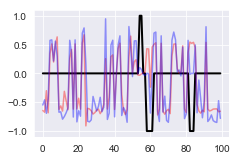

In [97]:
import seaborn as sns
#from google.colab import files
sns.set_style("darkgrid")
plt.figure(figsize=(3.5,2.3333333333))
#plt.xticks(ticks=[0,20,40,60,80,100],labels=[8225,8245,8265,8285,8305,8325],fontsize='xx-small') 
#plt.yticks(fontsize='xx-small') 
plt.plot(inventories, color="k", linewidth=2)
plt.plot(actions_up, color="r", alpha=0.4)
plt.plot(actions_down, color="b", alpha=0.4)
#plt.xlabel("Environmental step", fontsize='xx-small')
#plt.ylabel("Inventory level/scaled actions", fontsize='xx-small')
#plt.legend(["Inventory","Bid offset (scaled)","Ask offset (scaled)"], fontsize='xx-small')
#plt.tight_layout(0.4)
#plt.ticklabel_format(axis='x', scilimits=(0,0))
#plt.savefig('gaspe4.pdf', dpi=300)
#files.download('gaspe4.pdf')

In [ ]:
env = marketmakingenv()
observation = env.reset()
while True:
    env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    #print(action)
    observation, reward, done, info = env.step(action)
    print(reward)
    if done:
        break
env.close()

In [ ]:
model = TD3('MlpPolicy', env, verbose=1, gamma=1)

In [ ]:
model.learn(2500000)

In [98]:
drl_sharpes =[1.61934975045, 1.33629129807, 0.67659890312, -0.22609075653]
lin_sharpes =[1.41844032893, 0.6023356803, -0.30508215279, -1.28366777371]
sym_sharpes =[1.19702097207, -1.24133820337, -4.22779081998, -5.78760910093]

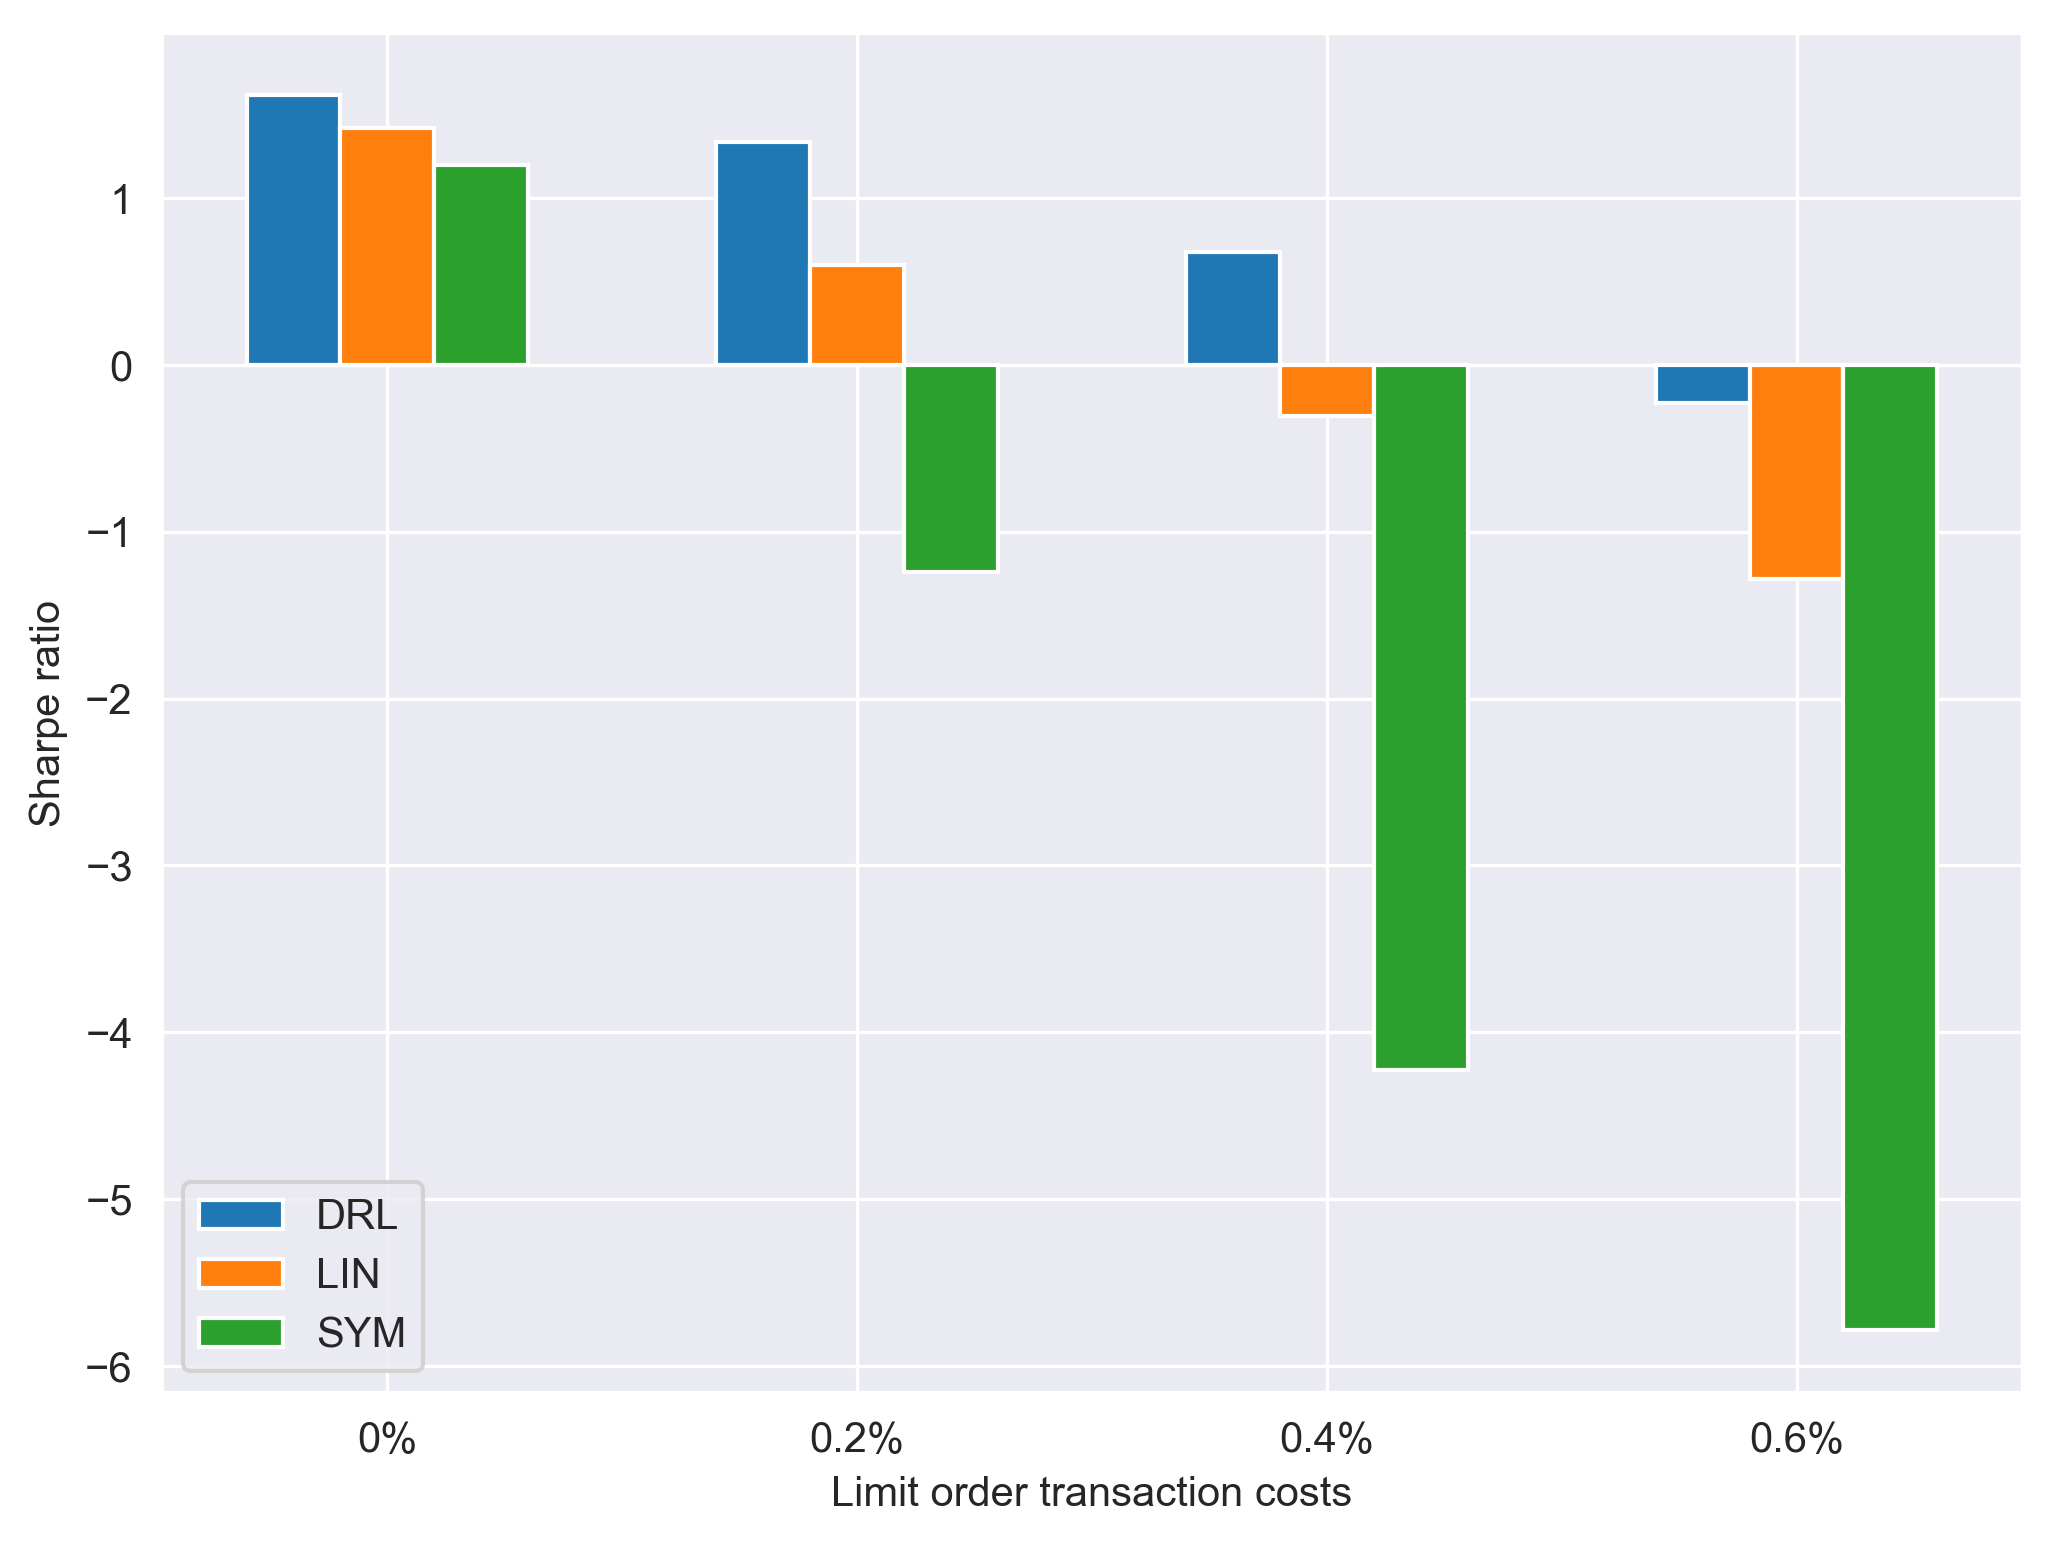

In [121]:
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['0%','0.2%', '0.4%', '0.6%',]
drl_sharpes = [1.61934975045, 1.33629129807, 0.67659890312, -0.22609075653]
lin_sharpes = [1.41844032893, 0.6023356803, -0.30508215279, -1.28366777371]
sym_sharpes =[1.19702097207, -1.24133820337, -4.22779081998, -5.78760910093]

X_axis = np.arange(len(X))
plt.figure(figsize=(8, 6), dpi=300)
plt.bar(X_axis - 0.20, drl_sharpes, 0.2, label = 'DRL')
plt.bar(X_axis + 0, lin_sharpes, 0.2, label = 'LIN')
plt.bar(X_axis + 0.20, sym_sharpes, 0.2, label = 'SYM')
  
plt.xticks(X_axis, X)
plt.xlabel("Limit order transaction costs")
plt.ylabel("Sharpe ratio")
#plt.title("Number of Students in each group")
plt.legend(loc='lower left')
#plt.savefig("costs1.pdf")
plt.show()